In [1]:
# Functions to use

import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd 

In [2]:
#DATA LOAD

file_path = 'C:/Users/denis/OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey/PhD/Congresos, estancias, etc/UBC/Mitacs/Project/Participants'
subject='8'


file_D0 = file_path + '/P' + subject + '/D0-epo.fif'
file_D1 = file_path + '/P' + subject + '/D1-epo.fif'
file_D2 = file_path + '/P' + subject + '/D2-epo.fif'
file_D3 = file_path + '/P' + subject + '/D3-epo.fif' 

file_ND0 = file_path + '/P' + subject + '/ND0-epo.fif'
file_ND1 = file_path + '/P' + subject + '/ND1-epo.fif'
file_ND2 = file_path + '/P' + subject + '/ND2-epo.fif'
file_ND3 = file_path + '/P' + subject + '/ND3-epo.fif'  

# Load the data from each file
epochs_D0 = mne.read_epochs(file_D0)
epochs_D1 = mne.read_epochs(file_D1)
epochs_D2 = mne.read_epochs(file_D2)
epochs_D3 = mne.read_epochs(file_D3)

epochs_ND0 = mne.read_epochs(file_ND0)
epochs_ND1 = mne.read_epochs(file_ND1)
epochs_ND2 = mne.read_epochs(file_ND2)
epochs_ND3 = mne.read_epochs(file_ND3)

# Function to convert data to microvolts
def convert_to_microvolts(epoch_data):
    return epoch_data * 1e6

# Concatenate the epochs for each class
epochs_D = mne.concatenate_epochs([epochs_D0, epochs_D1, epochs_D2, epochs_D3])
epochs_ND = mne.concatenate_epochs([epochs_ND0, epochs_ND1, epochs_ND2, epochs_ND3])

# Apply the conversion to each epoch
epochs_D.apply_function(convert_to_microvolts)
epochs_ND.apply_function(convert_to_microvolts)


# Create labels for each class
# Class 1 for D0 and D1
labels_D = [1] * len(epochs_D)

# Class 0 for ND0 and ND1
labels_ND = [0] * len(epochs_ND)

# Combine the epochs from both classes
epochs_all = mne.concatenate_epochs([epochs_D, epochs_ND])

# Combine the labels
labels_all = labels_D + labels_ND

# Convert labels to numpy array for further processing
labels_all = np.array(labels_all)

# Print information about the combined data
print(f"Total epochs: {len(epochs_all)}")
print(f"Labels distribution: {np.bincount(labels_all)}")

# Get information about the channels
n_channels = epochs_all.info['nchan']
channel_names = epochs_all.info['ch_names']
sfreq = epochs_all.info['sfreq']

print(f"Number of channels: {n_channels}")
print(f"Channel names: {channel_names}")
print(f"sfreq: {sfreq}")

# Calculate the min and max values for the D condition
data_D = epochs_D.get_data()  # Shape is (n_epochs, n_channels, n_times)
min_val_D = data_D.min()
max_val_D = data_D.max()


print(f'Data range for D condition: min = {min_val_D}, max = {max_val_D}')

Reading C:\Users\denis\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\PhD\Congresos, estancias, etc\UBC\Mitacs\Project\Participants\P8\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
102 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\denis\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\PhD\Congresos, estancias, etc\UBC\Mitacs\Project\Participants\P8\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
108 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\denis\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\PhD\Congresos, estancias, etc\UBC\Mitacs\Project\Participants\P8\D2-epo.fif ...
    Found the data of inte

C:\Users\denis\AppData\Local\Temp\ipykernel_37924\3571181142.py:33: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_D = mne.concatenate_epochs([epochs_D0, epochs_D1, epochs_D2, epochs_D3])
C:\Users\denis\AppData\Local\Temp\ipykernel_37924\3571181142.py:34: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_ND = mne.concatenate_epochs([epochs_ND0, epochs_ND1, epochs_ND2, epochs_ND3])


Not setting metadata
983 matching events found
No baseline correction applied
Total epochs: 983
Labels distribution: [501 482]
Number of channels: 62
Channel names: ['1Z', '2Z', '3Z', '4Z', '6Z', '7Z', '8Z', '9Z', '1L', '2L', '3L', '4L', '5L', '6L', '7L', '8L', '9L', '10L', '1R', '2R', '3R', '4R', '5R', '6R', '7R', '8R', '9R', '10R', '1LA', '2LA', '3LA', '1LB', '2LB', '3LB', '4LB', '5LB', '1LC', '2LC', '3LC', '4LC', '5LC', '1LD', '2LD', '3LD', '4LD', '1RA', '2RA', '3RA', '1RB', '2RB', '3RB', '4RB', '5RB', '1RC', '2RC', '3RC', '4RC', '5RC', '1RD', '2RD', '3RD', '4RD']
sfreq: 250.0
Data range for D condition: min = -65.63460192410275, max = 55.87869600276463


C:\Users\denis\AppData\Local\Temp\ipykernel_37924\3571181142.py:71: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_D = epochs_D.get_data()  # Shape is (n_epochs, n_channels, n_times)


In [33]:
from scipy.stats import wilcoxon
# Define frequency bands
bands = {
    #'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30),
    #'gamma': (30, 45)
}

# Function to calculate PSD for each epoch and frequency band
def calculate_psd_per_epoch(epochs, bands, sfreq):
    psds = []  # Store all PSDs per epoch
    freqs = None
    
    # Get PSD for each epoch
    for epoch in epochs.get_data():
        psd, freqs = mne.time_frequency.psd_array_multitaper(epoch, sfreq=sfreq, fmin=4., fmax=30., verbose=False)
        psds.append(psd)  # Append the PSD for the current epoch
    
    psds = np.array(psds)  # Convert to numpy array (n_epochs, n_channels, n_frequencies)
    
    band_powers = {band: [] for band in bands}  # Dictionary to store band powers
    
    # Calculate power in each frequency band for each epoch
    for band, (fmin, fmax) in bands.items():
        freq_mask = (freqs >= fmin) & (freqs <= fmax)  # Mask to select frequencies in the current band
        band_power = np.mean(psds[:, :, freq_mask], axis=-1)  # Average PSD over the selected frequencies
        band_powers[band] = band_power  # Store the band power for the current band (n_epochs, n_channels)
    
    return band_powers

# Example to calculate PSD for each condition (D and ND):
# Calculate PSD per epoch for condition D
band_powers_D = calculate_psd_per_epoch(epochs_D, bands, sfreq)

# Calculate PSD per epoch for condition ND
band_powers_ND = calculate_psd_per_epoch(epochs_ND, bands, sfreq)

# Display the shapes of the band powers for verification
for band, power in band_powers_D.items():
    print(f"Condición D - Banda {band}: {power.shape} (n_epochs, n_channels)")

for band, power in band_powers_ND.items():
    print(f"Condición ND - Banda {band}: {power.shape} (n_epochs, n_channels)")

C:\Users\denis\AppData\Local\Temp\ipykernel_37924\3786094696.py:17: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch in epochs.get_data():
C:\Users\denis\AppData\Local\Temp\ipykernel_37924\3786094696.py:17: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch in epochs.get_data():


Condición D - Banda theta: (482, 62) (n_epochs, n_channels)
Condición D - Banda alpha: (482, 62) (n_epochs, n_channels)
Condición D - Banda beta: (482, 62) (n_epochs, n_channels)
Condición ND - Banda theta: (501, 62) (n_epochs, n_channels)
Condición ND - Banda alpha: (501, 62) (n_epochs, n_channels)
Condición ND - Banda beta: (501, 62) (n_epochs, n_channels)


In [35]:
# Function to calculate engagement index per epoch and channel
def calculate_engagement_index(band_powers):
    # Engagement index = Beta / (Alpha + Theta)
    beta_power = band_powers['beta']  # (n_epochs, n_channels)
    alpha_power = band_powers['alpha']  # (n_epochs, n_channels)
    theta_power = band_powers['theta']  # (n_epochs, n_channels)
    
    # Calculate engagement index
    engagement_index = beta_power / (alpha_power + theta_power)
    
    return engagement_index  # (n_epochs, n_channels)





# Function to ensure both conditions have the same number of epochs
def trim_epochs_to_min(engagement_index_D, engagement_index_ND):
    # Find the minimum number of epochs between the two conditions
    min_epochs = min(engagement_index_D.shape[0], engagement_index_ND.shape[0])
    
    # Trim both engagement index arrays to the minimum number of epochs
    engagement_index_D_trimmed = engagement_index_D[:min_epochs, :]
    engagement_index_ND_trimmed = engagement_index_ND[:min_epochs, :]
    
    return engagement_index_D_trimmed, engagement_index_ND_trimmed

# Calculate engagement index for each condition
engagement_index_D = calculate_engagement_index(band_powers_D)
engagement_index_ND = calculate_engagement_index(band_powers_ND)

# Trim both engagement index arrays to have the same number of epochs
engagement_index_D_trimmed, engagement_index_ND_trimmed = trim_epochs_to_min(engagement_index_D, engagement_index_ND)

# Display the shapes after trimming
print(f"Engagement Index - Condición D (recortado): {engagement_index_D_trimmed.shape} (n_epochs, n_channels)")
print(f"Engagement Index - Condición ND (recortado): {engagement_index_ND_trimmed.shape} (n_epochs, n_channels)")


Engagement Index - Condición D (recortado): (482, 62) (n_epochs, n_channels)
Engagement Index - Condición ND (recortado): (482, 62) (n_epochs, n_channels)


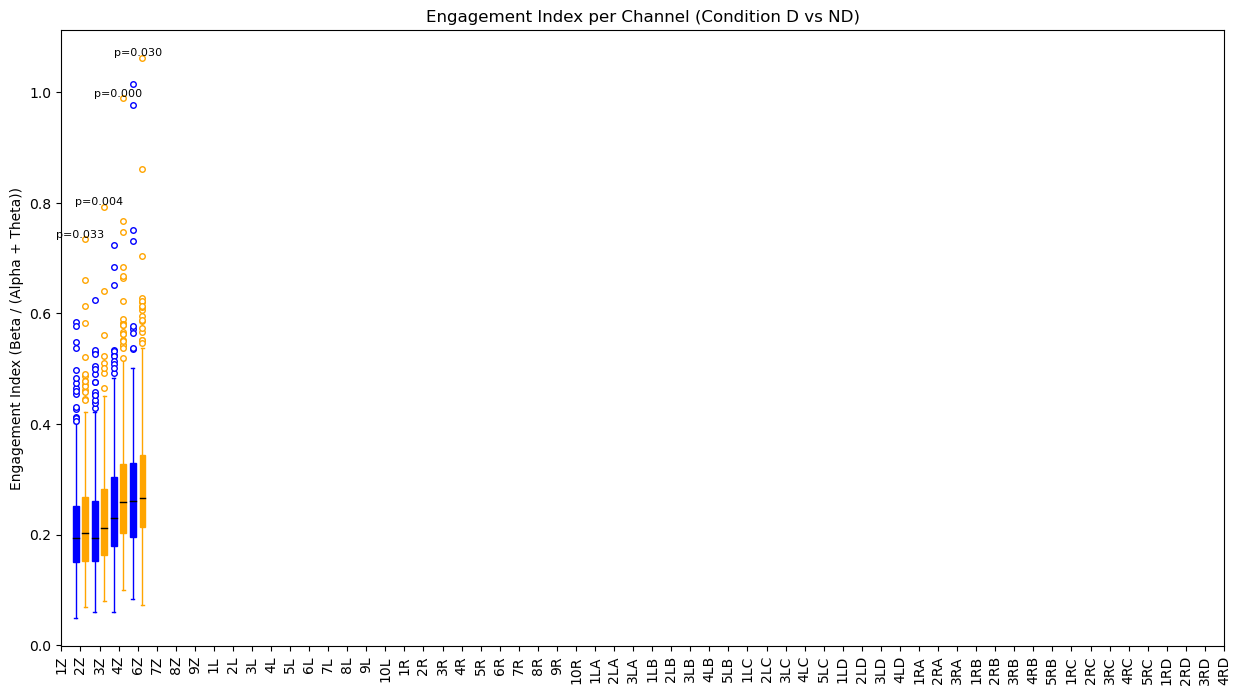

In [55]:
from scipy.stats import wilcoxon
import numpy as np
import matplotlib.pyplot as plt



# Plot boxplots and perform Wilcoxon test
def plot_boxplot_and_wilcoxon(engagement_index_D, engagement_index_ND, channels):
    n_channels = engagement_index_D.shape[1]
    fig, ax = plt.subplots(figsize=(15, 8))

    # Define colors for each condition
    colors = {'D': 'blue', 'ND': 'orange'}

    # Boxplot for each channel
    for i in range(1,5):
        data = [engagement_index_D[:, i], engagement_index_ND[:, i]]
        # Boxplots for ND and D conditions with different colors
        box_D = ax.boxplot(data[0], positions=[i*2], widths=0.6, patch_artist=True,
                           boxprops=dict(facecolor=colors['D'], color=colors['D']),
                           medianprops=dict(color='black'),
                           whiskerprops=dict(color=colors['D']),
                           capprops=dict(color=colors['D']),
                           flierprops=dict(marker='o', markeredgecolor='blue', markersize=4, markerfacecolor='white')) 
        
        box_ND = ax.boxplot(data[1], positions=[i*2+1], widths=0.6, patch_artist=True,
                            boxprops=dict(facecolor=colors['ND'], color=colors['ND']),
                            medianprops=dict(color='black'),
                            whiskerprops=dict(color=colors['ND']),
                            capprops=dict(color=colors['ND']),
                            flierprops=dict(marker='o', markeredgecolor='orange', markersize=4, markerfacecolor='white')) 

        # Perform Wilcoxon test between conditions for each channel if enough samples are available
        if len(engagement_index_D[:, i]) == len(engagement_index_ND[:, i]):
            stat, p_value = wilcoxon(engagement_index_D[:, i], engagement_index_ND[:, i])
            ax.text(i*2+0.5, np.max(data), f'p={p_value:.3f}', ha='center', va='bottom', fontsize=8)
    
    ax.set_xticks(np.arange(0, n_channels * 2, 2) + 0.5)
    ax.set_xticklabels(channels, rotation=90)
    ax.set_ylabel('Engagement Index (Beta / (Alpha + Theta))')
    ax.set_title('Engagement Index per Channel (Condition D vs ND)')
    plt.show()

# Get channel names
channels = epochs_D.ch_names

# Plot boxplots and perform Wilcoxon test
plot_boxplot_and_wilcoxon(engagement_index_D_trimmed, engagement_index_ND_trimmed, channels)

In [40]:
a=engagement_index_D.shape
print(a)

(482, 62)
